# <span style="font-width:bold; font-size: 3rem; color:#1EB182;"> **Air Quality** </span><span style="font-width:bold; font-size: 3rem; color:#333;">- Part 04: Batch Inference</span>

## 🗒️ This notebook is divided into the following sections:

1. Download model and batch inference data
2. Make predictions, generate PNG for forecast
3. Store predictions in a monitoring feature group and generate PNG for hindcast

## <span style='color:#ff5f27'> 📝 Imports

In [1]:
import sys
from pathlib import Path

def is_google_colab() -> bool:
    if "google.colab" in str(get_ipython()):
        return True
    return False

def clone_repository() -> None:
    !git clone https://github.com/featurestorebook/mlfs-book.git
    %cd mlfs-book

def install_dependencies() -> None:
    !pip install --upgrade uv
    !uv pip install --all-extras --system --requirement pyproject.toml


if is_google_colab():
    clone_repository()
    install_dependencies()
    root_dir = str(Path().absolute())
    print("Google Colab environment")
else:
    root_dir = Path().absolute()
    # Strip ~/notebooks/ccfraud from PYTHON_PATH if notebook started in one of these subdirectories
    if root_dir.parts[-1:] == ('airquality',):
        root_dir = Path(*root_dir.parts[:-1])
    if root_dir.parts[-1:] == ('notebooks',):
        root_dir = Path(*root_dir.parts[:-1])
    root_dir = str(root_dir) 
    print("Local environment")

# Add the root directory to the `PYTHONPATH` to use the `recsys` Python module from the notebook.
if root_dir not in sys.path:
    sys.path.append(root_dir)
print(f"Added the following directory to the PYTHONPATH: {root_dir}")
    
# Read the API keys and configuration variables from the file <root_dir>/.env
from mlfs import config
settings = config.HopsworksSettings(_env_file=f"{root_dir}/.env")

Local environment
Added the following directory to the PYTHONPATH: d:\Studied\Scalable Machine Learning\ID2223_LAB1_AirQuality
HopsworksSettings initialized!


In [2]:
import datetime
import pandas as pd
from xgboost import XGBRegressor
import hopsworks
import json
from mlfs.airquality import util
import os

In [3]:
today = datetime.datetime.now() - datetime.timedelta(0)
tomorrow = today + datetime.timedelta(days = 1)
today

datetime.datetime(2025, 11, 16, 15, 48, 26, 522984)

## <span style="color:#ff5f27;"> 📡 Connect to Hopsworks Feature Store </span>

In [4]:
project = hopsworks.login()
fs = project.get_feature_store() 

secrets = hopsworks.get_secrets_api()
location_str = secrets.get_secret("SENSOR_LOCATION_JSON").value
location = json.loads(location_str)
country=location['country']
city=location['city']
street=location['street']

2025-11-16 15:48:26,541 INFO: Initializing external client
2025-11-16 15:48:26,542 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-11-16 15:48:27,810 WARNING: UserWarning: The installed hopsworks client version 4.4.2 may not be compatible with the connected Hopsworks backend version 4.2.2. 
To ensure compatibility please install the latest bug fix release matching the minor version of your backend (4.2) by running 'pip install hopsworks==4.2.*'



2025-11-16 15:48:33,826 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1271980


## <span style="color:#ff5f27;">🪝 Download the model from Model Registry</span>

In [5]:
mr = project.get_model_registry()

retrieved_model = mr.get_model(
    name="air_quality_xgboost_model",
    version=1,
)

fv = retrieved_model.get_feature_view()

# Download the saved model artifacts to a local directory
saved_model_dir = retrieved_model.download()

2025-11-16 15:48:38,546 INFO: Initializing for batch retrieval of feature vectors


Downloading: 0.000%|          | 0/546229 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/118363 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/20122 elapsed<00:00 remaining<?

In [6]:
# Loading the XGBoost regressor model and label encoder from the saved model directory
# retrieved_xgboost_model = joblib.load(saved_model_dir + "/xgboost_regressor.pkl")
retrieved_xgboost_model = XGBRegressor()

retrieved_xgboost_model.load_model(saved_model_dir + "/model.json")

# Displaying the retrieved XGBoost regressor model
retrieved_xgboost_model

XGBRegressor(base_score='1.0923033E2', booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             feature_types=['float', 'float', 'float', 'float'], gamma=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## <span style="color:#ff5f27;">✨ Get Weather Forecast Features with Feature View   </span>



In [7]:
weather_fg = fs.get_feature_group(
    name='weather',
    version=1,
)
batch_data = weather_fg.filter(weather_fg.date >= today).read()
batch_data

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.70s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city
0,2025-11-17 00:00:00+00:00,0.40,0.0,10.464797,319.185028,beijing
1,2025-11-18 00:00:00+00:00,3.75,0.0,5.904439,307.568665,beijing
2,2025-11-19 00:00:00+00:00,5.25,0.0,6.792466,237.994659,beijing
3,2025-11-20 00:00:00+00:00,5.55,0.0,10.195057,227.862473,beijing
4,2025-11-21 00:00:00+00:00,6.10,0.0,13.392774,216.253922,beijing
5,2025-11-22 00:00:00+00:00,4.10,0.0,2.902413,187.124924,beijing


### <span style="color:#ff5f27;">🤖 Making the predictions</span>

In [8]:
batch_data['predicted_pm25'] = retrieved_xgboost_model.predict(
    batch_data[['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant']])
batch_data

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,predicted_pm25
0,2025-11-17 00:00:00+00:00,0.40,0.0,10.464797,319.185028,beijing,96.938484
1,2025-11-18 00:00:00+00:00,3.75,0.0,5.904439,307.568665,beijing,294.513916
2,2025-11-19 00:00:00+00:00,5.25,0.0,6.792466,237.994659,beijing,76.730995
3,2025-11-20 00:00:00+00:00,5.55,0.0,10.195057,227.862473,beijing,92.010612
4,2025-11-21 00:00:00+00:00,6.10,0.0,13.392774,216.253922,beijing,138.642609
5,2025-11-22 00:00:00+00:00,4.10,0.0,2.902413,187.124924,beijing,99.367012


In [9]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 7 columns):
 #   Column                       Non-Null Count  Dtype                  
---  ------                       --------------  -----                  
 0   date                         6 non-null      datetime64[us, Etc/UTC]
 1   temperature_2m_mean          6 non-null      float32                
 2   precipitation_sum            6 non-null      float32                
 3   wind_speed_10m_max           6 non-null      float32                
 4   wind_direction_10m_dominant  6 non-null      float32                
 5   city                         6 non-null      object                 
 6   predicted_pm25               6 non-null      float32                
dtypes: datetime64[us, Etc/UTC](1), float32(5), object(1)
memory usage: 344.0+ bytes


### <span style="color:#ff5f27;">🤖 Saving the predictions (for monitoring) to a Feature Group</span>

In [10]:
batch_data['street'] = street
batch_data['city'] = city
batch_data['country'] = country
# Fill in the number of days before the date on which you made the forecast (base_date)
batch_data['days_before_forecast_day'] = range(1, len(batch_data)+1)
batch_data = batch_data.sort_values(by=['date'])
batch_data

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,predicted_pm25,street,country,days_before_forecast_day
0,2025-11-17 00:00:00+00:00,0.40,0.0,10.464797,319.185028,beijing,96.938484,dongchengdongsi,china,1
1,2025-11-18 00:00:00+00:00,3.75,0.0,5.904439,307.568665,beijing,294.513916,dongchengdongsi,china,2
2,2025-11-19 00:00:00+00:00,5.25,0.0,6.792466,237.994659,beijing,76.730995,dongchengdongsi,china,3
3,2025-11-20 00:00:00+00:00,5.55,0.0,10.195057,227.862473,beijing,92.010612,dongchengdongsi,china,4
4,2025-11-21 00:00:00+00:00,6.10,0.0,13.392774,216.253922,beijing,138.642609,dongchengdongsi,china,5
5,2025-11-22 00:00:00+00:00,4.10,0.0,2.902413,187.124924,beijing,99.367012,dongchengdongsi,china,6


In [11]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype                  
---  ------                       --------------  -----                  
 0   date                         6 non-null      datetime64[us, Etc/UTC]
 1   temperature_2m_mean          6 non-null      float32                
 2   precipitation_sum            6 non-null      float32                
 3   wind_speed_10m_max           6 non-null      float32                
 4   wind_direction_10m_dominant  6 non-null      float32                
 5   city                         6 non-null      object                 
 6   predicted_pm25               6 non-null      float32                
 7   street                       6 non-null      object                 
 8   country                      6 non-null      object                 
 9   days_before_forecast_day     6 non-null      int64                  
dtypes: dat

### Create Forecast Graph
Draw a graph of the predictions with dates as a PNG and save it to the github repo
Show it on github pages

2025-11-16 15:48:45,203 WARNING: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.



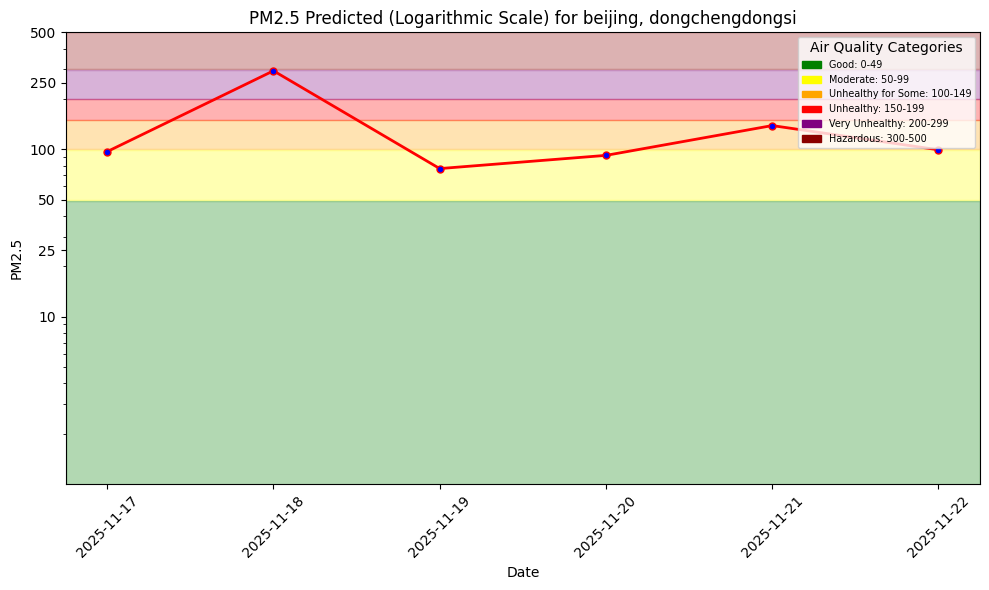

In [12]:

pred_file_path = f"{root_dir}/docs/air-quality/assets/img/pm25_forecast.png"
plt = util.plot_air_quality_forecast(city, street, batch_data, pred_file_path)

plt.show()

In [13]:
# Get or create feature group
monitor_fg = fs.get_or_create_feature_group(
    name='aq_predictions',
    description='Air Quality prediction monitoring',
    version=1,
    primary_key=['city','street','date','days_before_forecast_day'],
    event_time="date"
)

In [14]:
monitor_fg.insert(batch_data, wait=True)

Uploading Dataframe: 100.00% |██████████| Rows 6/6 | Elapsed Time: 00:01 | Remaining Time: 00:00


Launching job: aq_predictions_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1271980/jobs/named/aq_predictions_1_offline_fg_materialization/executions
2025-11-16 15:49:03,043 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-11-16 15:49:06,229 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-11-16 15:50:48,354 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-11-16 15:50:48,510 INFO: Waiting for log aggregation to finish.
2025-11-16 15:50:57,103 INFO: Execution finished successfully.


(Job('aq_predictions_1_offline_fg_materialization', 'SPARK'), None)

In [15]:
test_df=monitor_fg.read()
test_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.27s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,predicted_pm25,street,country,days_before_forecast_day
0,2025-11-18 00:00:00+00:00,1.950000,0.0,3.259938,263.659912,beijing,174.065857,dongchengdongsi,china,4
1,2025-11-17 00:00:00+00:00,0.450000,0.0,8.714677,321.709778,beijing,150.738434,dongchengdongsi,china,3
2,2025-11-15 00:00:00+00:00,10.100000,0.0,11.113451,204.904739,beijing,104.870705,dongchengdongsi,china,1
3,2025-11-16 00:00:00+00:00,0.450000,0.0,9.422101,316.548096,beijing,60.453598,dongchengdongsi,china,2
4,2025-11-19 00:00:00+00:00,3.900000,0.0,6.952754,248.749420,beijing,46.074215,dongchengdongsi,china,5
5,2025-11-20 00:00:00+00:00,4.200000,0.0,8.373386,244.536697,beijing,53.463051,dongchengdongsi,china,6
6,2025-11-11 00:00:00+00:00,8.131083,0.0,6.424764,20.763519,beijing,195.435425,dongchengdongsi,china,1
7,2025-11-14 00:00:00+00:00,8.450000,0.0,3.826853,221.185822,beijing,145.523193,dongchengdongsi,china,1
8,2025-11-12 00:00:00+00:00,10.224834,0.0,17.604149,336.089874,beijing,59.493561,dongchengdongsi,china,1
9,2025-11-13 00:00:00+00:00,9.400000,0.0,9.028754,203.498581,beijing,143.256546,dongchengdongsi,china,1


In [16]:
# We will create a hindcast chart for  only the forecasts made 1 day beforehand
monitoring_df = monitor_fg.filter(monitor_fg.days_before_forecast_day == 1).read()
monitoring_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.67s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,predicted_pm25,street,country,days_before_forecast_day
0,2025-11-15 00:00:00+00:00,10.100000,0.0,11.113451,204.904739,beijing,104.870705,dongchengdongsi,china,1
1,2025-11-11 00:00:00+00:00,8.131083,0.0,6.424764,20.763519,beijing,195.435425,dongchengdongsi,china,1
2,2025-11-14 00:00:00+00:00,8.450000,0.0,3.826853,221.185822,beijing,145.523193,dongchengdongsi,china,1
3,2025-11-12 00:00:00+00:00,10.224834,0.0,17.604149,336.089874,beijing,59.493561,dongchengdongsi,china,1
4,2025-11-13 00:00:00+00:00,9.400000,0.0,9.028754,203.498581,beijing,143.256546,dongchengdongsi,china,1
5,2025-11-16 00:00:00+00:00,0.450000,0.0,8.891343,301.759430,beijing,148.406021,dongchengdongsi,china,1
6,2025-11-17 00:00:00+00:00,0.400000,0.0,10.464797,319.185028,beijing,96.938484,dongchengdongsi,china,1


In [17]:
air_quality_fg = fs.get_feature_group(name='air_quality', version=1)
air_quality_df = air_quality_fg.read()
air_quality_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.13s) 


,date,pm25,country,city,street,url
0,2023-03-28 00:00:00+00:00,148.0,china,beijing,dongchengdongsi,https://api.waqi.info/feed/@446
1,2022-09-07 00:00:00+00:00,44.0,china,beijing,dongchengdongsi,https://api.waqi.info/feed/@446
2,2014-01-30 00:00:00+00:00,117.0,china,beijing,dongchengdongsi,https://api.waqi.info/feed/@446
3,2023-09-29 00:00:00+00:00,54.0,china,beijing,dongchengdongsi,https://api.waqi.info/feed/@446
4,2024-03-12 00:00:00+00:00,77.0,china,beijing,dongchengdongsi,https://api.waqi.info/feed/@446
...,...,...,...,...,...,...
4250,2025-11-12 00:00:00+00:00,171.0,china,beijing,dongchengdongsi,https://api.waqi.info/feed/@446
4251,2025-11-13 00:00:00+00:00,21.0,china,beijing,dongchengdongsi,https://api.waqi.info/feed/@446
4252,2025-11-14 00:00:00+00:00,93.0,china,beijing,dongchengdongsi,https://api.waqi.info/feed/@446
4253,2025-11-15 00:00:00+00:00,63.0,china,beijing,dongchengdongsi,https://api.waqi.info/feed/@446


In [18]:
outcome_df = air_quality_df[['date', 'pm25']]
preds_df =  monitoring_df[['date', 'predicted_pm25']]
print(outcome_df)
print(preds_df)


                          date   pm25
0    2023-03-28 00:00:00+00:00  148.0
1    2022-09-07 00:00:00+00:00   44.0
2    2014-01-30 00:00:00+00:00  117.0
3    2023-09-29 00:00:00+00:00   54.0
4    2024-03-12 00:00:00+00:00   77.0
...                        ...    ...
4250 2025-11-12 00:00:00+00:00  171.0
4251 2025-11-13 00:00:00+00:00   21.0
4252 2025-11-14 00:00:00+00:00   93.0
4253 2025-11-15 00:00:00+00:00   63.0
4254 2025-11-16 00:00:00+00:00   13.0

[4255 rows x 2 columns]
                       date  predicted_pm25
0 2025-11-15 00:00:00+00:00      104.870705
1 2025-11-11 00:00:00+00:00      195.435425
2 2025-11-14 00:00:00+00:00      145.523193
3 2025-11-12 00:00:00+00:00       59.493561
4 2025-11-13 00:00:00+00:00      143.256546
5 2025-11-16 00:00:00+00:00      148.406021
6 2025-11-17 00:00:00+00:00       96.938484


In [19]:
hindcast_df = pd.merge(preds_df, outcome_df, on="date")
hindcast_df = hindcast_df.sort_values(by=['date'])

# If there are no outcomes for predictions yet, generate some predictions/outcomes from existing data
if len(hindcast_df) == 0:
    hindcast_df = util.backfill_predictions_for_monitoring(weather_fg, air_quality_df, monitor_fg, retrieved_xgboost_model)
hindcast_df

,date,predicted_pm25,pm25
1,2025-11-11 00:00:00+00:00,195.435425,99.0
3,2025-11-12 00:00:00+00:00,59.493561,171.0
4,2025-11-13 00:00:00+00:00,143.256546,21.0
2,2025-11-14 00:00:00+00:00,145.523193,93.0
0,2025-11-15 00:00:00+00:00,104.870705,63.0
5,2025-11-16 00:00:00+00:00,148.406021,13.0


### Plot the Hindcast comparing predicted with forecasted values (1-day prior forecast)

__This graph will be empty to begin with - this is normal.__

After a few days of predictions and observations, you will get data points in this graph.

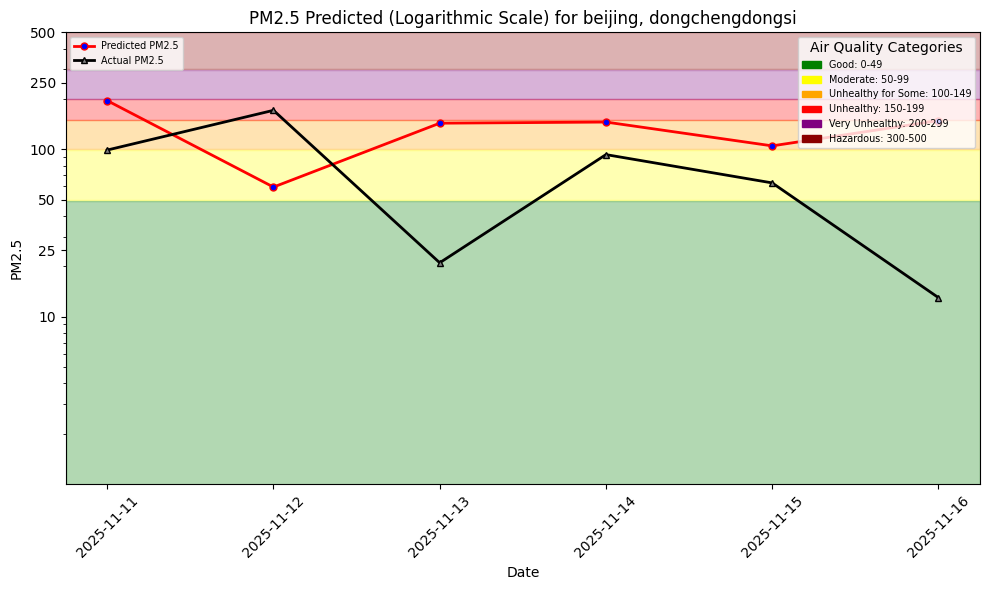

In [20]:
hindcast_file_path = f"{root_dir}/docs/air-quality/assets/img/pm25_hindcast_1day.png"
plt = util.plot_air_quality_forecast(city, street, hindcast_df, hindcast_file_path, hindcast=True)
plt.show()

### Upload the prediction and hindcast dashboards (png files) to Hopsworks


In [21]:
dataset_api = project.get_dataset_api()
str_today = today.strftime("%Y-%m-%d")
if dataset_api.exists("Resources/airquality") == False:
    dataset_api.mkdir("Resources/airquality")
dataset_api.upload(pred_file_path, f"Resources/airquality/{city}_{street}_{str_today}", overwrite=True)
dataset_api.upload(hindcast_file_path, f"Resources/airquality/{city}_{street}_{str_today}", overwrite=True)

proj_url = project.get_url()
print(f"See images in Hopsworks here: {proj_url}/settings/fb/path/Resources/airquality")

Uploading d:\Studied\Scalable Machine Learning\ID2223_LAB1_AirQuality/docs/air-quality/assets/img/pm25_forecas…

Uploading d:\Studied\Scalable Machine Learning\ID2223_LAB1_AirQuality/docs/air-quality/assets/img/pm25_hindcas…

See images in Hopsworks here: https://c.app.hopsworks.ai:443/p/1271980/settings/fb/path/Resources/airquality


---

### For Grade C

In [22]:
# === Grade C / Lag 版本：加载模型 ===

from xgboost import XGBRegressor

mr = project.get_model_registry()

lag_model = mr.get_model(
    name="air_quality_xgboost_model_C",
    version=1,   # 如果你后来又训练了新版本，这里改版本号
)

# 对应 lag 特征的 feature view（air_quality v2）
feature_view_v2 = lag_model.get_feature_view()

# 下载 C 模型的本地目录
lag_saved_model_dir = lag_model.download()

# 加载 XGBoost 模型（和 training 里保存的一致）
retrieved_xgboost_model_C = XGBRegressor()
retrieved_xgboost_model_C.load_model(lag_saved_model_dir + "/model.json")

retrieved_xgboost_model_C


2025-11-16 15:51:11,119 INFO: Initializing for batch retrieval of feature vectors


Downloading: 0.000%|          | 0/544943 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/116607 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/26047 elapsed<00:00 remaining<?

XGBRegressor(base_score='1.0920459E2', booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             feature_types=['float', 'float', 'float', 'float', 'float',
                            'float', 'float'],
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [23]:
air_quality_fg_v2 = fs.get_feature_group(
    name="air_quality",
    version=2,
)
air_quality_df_v2=air_quality_fg_v2.read().sort_values("date")
# air_quality_df_v2
batch_data_v2 = air_quality_fg_v2.filter(air_quality_fg_v2.date >= today).read()
batch_data_v2


Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.16s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.59s) 


,date,pm25,country,city,street,url,pm25_lag1,pm25_lag2,pm25_lag3


In [24]:
batch_data_v2 = air_quality_fg_v2.filter(air_quality_fg_v2.date >= today).read()
batch_data_v2

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.67s) 


,date,pm25,country,city,street,url,pm25_lag1,pm25_lag2,pm25_lag3


In [25]:
import pandas as pd

# === 1. 读取 air_quality v2，拿到最近几天的 pm25，用作 lag 起点 ===
air_quality_fg_v2 = fs.get_feature_group(
    name="air_quality",
    version=2,
)
aq_hist = air_quality_fg_v2.read().sort_values("date")

# 确保有足够的历史点（至少 3 个）
aq_hist_tail = aq_hist.tail(7)   # 多拿几天也没问题
pm25_history = list(aq_hist_tail["pm25"].values)

# === 2. 读取未来天气数据 ===
weather_fg = fs.get_feature_group(
    name="weather",
    version=1,
)
weather_future = weather_fg.filter(weather_fg.date >= today).read()
weather_future = weather_future.sort_values("date")

# === 3. 递推生成未来几天的 lag 特征 + 预测 ===

# 注意：这里用“训练时的列名”，带 weather_ 前缀
feature_cols_C = [
    "pm25_lag1",
    "pm25_lag2",
    "pm25_lag3",
    "weather_temperature_2m_mean",
    "weather_precipitation_sum",
    "weather_wind_speed_10m_max",
    "weather_wind_direction_10m_dominant",
]

forecast_rows = []

for _, row in weather_future.iterrows():
    # 生成 lag1, lag2, lag3
    if len(pm25_history) < 3:
        pm25_lag1 = pm25_history[-1]
        pm25_lag2 = pm25_history[-1]
        pm25_lag3 = pm25_history[-1]
    else:
        pm25_lag1 = pm25_history[-1]
        pm25_lag2 = pm25_history[-2]
        pm25_lag3 = pm25_history[-3]

    # 注意：这里的 key 也要用 weather_ 前缀
    feature_row = {
        "pm25_lag1": pm25_lag1,
        "pm25_lag2": pm25_lag2,
        "pm25_lag3": pm25_lag3,
        "weather_temperature_2m_mean": row["temperature_2m_mean"],
        "weather_precipitation_sum": row["precipitation_sum"],
        "weather_wind_speed_10m_max": row["wind_speed_10m_max"],
        "weather_wind_direction_10m_dominant": row["wind_direction_10m_dominant"],
    }

    # 列名和训练时保持一致
    X_row = pd.DataFrame([feature_row])[feature_cols_C]

    # 这里就不会再 feature_names mismatch 了
    y_pred = retrieved_xgboost_model_C.predict(X_row)[0]

    # 把预测值加入历史，用于下一天的 lag
    pm25_history.append(y_pred)

    forecast_rows.append({
        "date": row["date"],
        "predicted_pm25": y_pred,
    })

batch_data_C = pd.DataFrame(forecast_rows)

# 加上地理信息和 days_before_forecast_day
batch_data_C["street"] = street
batch_data_C["city"] = city
batch_data_C["country"] = country
batch_data_C["days_before_forecast_day"] = range(1, len(batch_data_C) + 1)
batch_data_C = batch_data_C.sort_values(by=["date"])

batch_data_C


Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.07s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.69s) 


,date,predicted_pm25,street,city,country,days_before_forecast_day
0,2025-11-17 00:00:00+00:00,39.992542,dongchengdongsi,beijing,china,1
1,2025-11-18 00:00:00+00:00,77.948456,dongchengdongsi,beijing,china,2
2,2025-11-19 00:00:00+00:00,171.010071,dongchengdongsi,beijing,china,3
3,2025-11-20 00:00:00+00:00,220.926956,dongchengdongsi,beijing,china,4
4,2025-11-21 00:00:00+00:00,210.945618,dongchengdongsi,beijing,china,5
5,2025-11-22 00:00:00+00:00,177.761932,dongchengdongsi,beijing,china,6


In [26]:
monitor_fg_c = fs.get_or_create_feature_group(
    name='aq_predictions_c',   # ✅ 全小写
    description='Air quality prediction monitoring (lag model c)',
    version=1,
    primary_key=['city', 'street', 'date', 'days_before_forecast_day'],
    event_time="date",
)

monitor_fg_c.insert(batch_data_C, wait=True)


Uploading Dataframe: 100.00% |██████████| Rows 6/6 | Elapsed Time: 00:01 | Remaining Time: 00:00


Launching job: aq_predictions_c_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1271980/jobs/named/aq_predictions_c_1_offline_fg_materialization/executions
2025-11-16 15:51:39,769 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-11-16 15:51:46,142 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-11-16 15:53:24,909 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-11-16 15:53:25,065 INFO: Waiting for log aggregation to finish.
2025-11-16 15:53:33,670 INFO: Execution finished successfully.


(Job('aq_predictions_c_1_offline_fg_materialization', 'SPARK'), None)

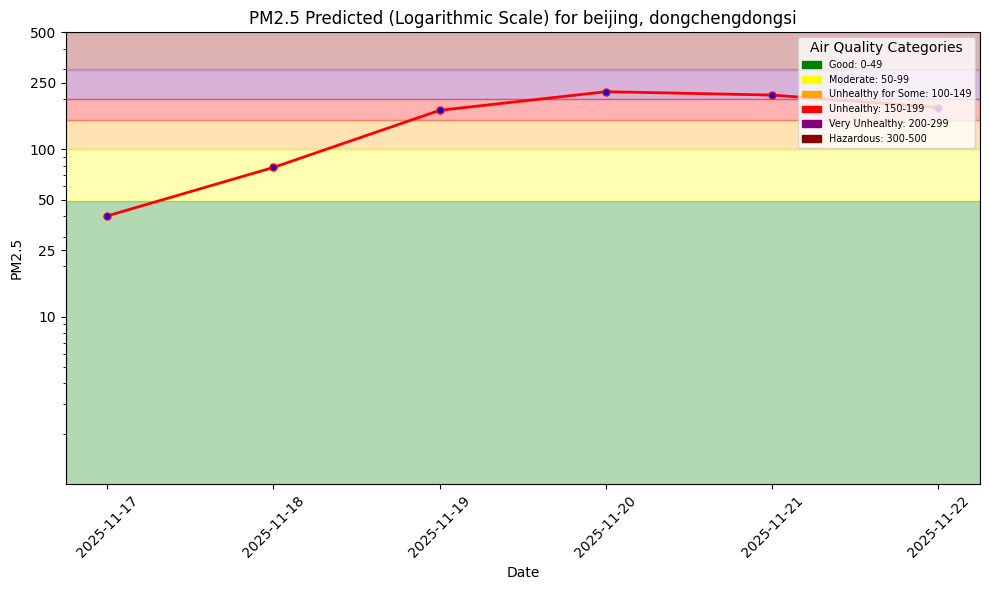

In [27]:
# === 画 lag 模型的预测图 ===
pred_file_path_C = f"{root_dir}/docs/air-quality/assets/img/pm25_forecast_C.png"

plt = util.plot_air_quality_forecast(
    city,
    street,
    batch_data_C,
    pred_file_path_C,
)
plt.show()


In [28]:
# We will create a hindcast chart for  only the forecasts made 1 day beforehand
# monitoring_df_v2 = monitor_fg_c.filter(monitor_fg_c.days_before_forecast_day == 1).read()
monitoring_df_v2 = monitor_fg_c.read()
monitoring_df_v2

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.04s) 


,date,predicted_pm25,street,city,country,days_before_forecast_day
0,2025-11-20 00:00:00+00:00,123.209091,dongchengdongsi,beijing,china,5
1,2025-11-19 00:00:00+00:00,141.292130,dongchengdongsi,beijing,china,4
2,2025-11-21 00:00:00+00:00,117.375862,dongchengdongsi,beijing,china,6
3,2025-11-18 00:00:00+00:00,129.354416,dongchengdongsi,beijing,china,3
4,2025-11-17 00:00:00+00:00,121.461403,dongchengdongsi,beijing,china,2
5,2025-11-16 00:00:00+00:00,100.171326,dongchengdongsi,beijing,china,1
6,2025-11-22 00:00:00+00:00,177.761932,dongchengdongsi,beijing,china,6
7,2025-11-20 00:00:00+00:00,220.926956,dongchengdongsi,beijing,china,4
8,2025-11-18 00:00:00+00:00,77.948456,dongchengdongsi,beijing,china,2
9,2025-11-19 00:00:00+00:00,171.010071,dongchengdongsi,beijing,china,3


In [29]:
air_quality_df_v2=air_quality_fg_v2.read()
air_quality_df_v2

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.14s) 


,date,pm25,country,city,street,url,pm25_lag1,pm25_lag2,pm25_lag3
0,2014-01-30 00:00:00+00:00,117.0,china,beijing,dongchengdongsi,https://api.waqi.info/feed/@446,197.0,103.0,142.0
1,2022-09-07 00:00:00+00:00,44.0,china,beijing,dongchengdongsi,https://api.waqi.info/feed/@446,29.0,19.0,97.0
2,2023-03-28 00:00:00+00:00,148.0,china,beijing,dongchengdongsi,https://api.waqi.info/feed/@446,70.0,87.0,79.0
3,2023-09-29 00:00:00+00:00,54.0,china,beijing,dongchengdongsi,https://api.waqi.info/feed/@446,35.0,104.0,136.0
4,2024-03-12 00:00:00+00:00,77.0,china,beijing,dongchengdongsi,https://api.waqi.info/feed/@446,118.0,170.0,109.0
...,...,...,...,...,...,...,...,...,...
4247,2025-11-12 00:00:00+00:00,171.0,china,beijing,dongchengdongsi,https://api.waqi.info/feed/@446,99.0,57.0,21.0
4248,2025-11-13 00:00:00+00:00,21.0,china,beijing,dongchengdongsi,https://api.waqi.info/feed/@446,171.0,99.0,57.0
4249,2025-11-14 00:00:00+00:00,93.0,china,beijing,dongchengdongsi,https://api.waqi.info/feed/@446,21.0,171.0,99.0
4250,2025-11-15 00:00:00+00:00,63.0,china,beijing,dongchengdongsi,https://api.waqi.info/feed/@446,93.0,21.0,171.0


In [30]:
outcome_df_v2 = air_quality_df_v2[['date', 'pm25']]
outcome_df_v2


,date,pm25
0,2014-01-30 00:00:00+00:00,117.0
1,2022-09-07 00:00:00+00:00,44.0
2,2023-03-28 00:00:00+00:00,148.0
3,2023-09-29 00:00:00+00:00,54.0
4,2024-03-12 00:00:00+00:00,77.0
...,...,...
4247,2025-11-12 00:00:00+00:00,171.0
4248,2025-11-13 00:00:00+00:00,21.0
4249,2025-11-14 00:00:00+00:00,93.0
4250,2025-11-15 00:00:00+00:00,63.0


In [31]:
outcome_df_v2 = air_quality_df_v2[['date', 'pm25']]
preds_df_v2 =  monitoring_df_v2[['date', 'predicted_pm25']]

hindcast_df_v2 = pd.merge(preds_df_v2, outcome_df_v2, on="date")
hindcast_df_v2 = hindcast_df_v2.sort_values(by=['date'])

# if len(hindcast_df_v2) == 0:
#     hindcast_df_v2 = util.backfill_predictions_for_monitoring(
#         weather_fg,
#         air_quality_df_v2,
#         monitor_fg_c,
#         retrieved_xgboost_model_C
#     )

hindcast_df_v2


,date,predicted_pm25,pm25
0,2025-11-16 00:00:00+00:00,100.171326,13.0


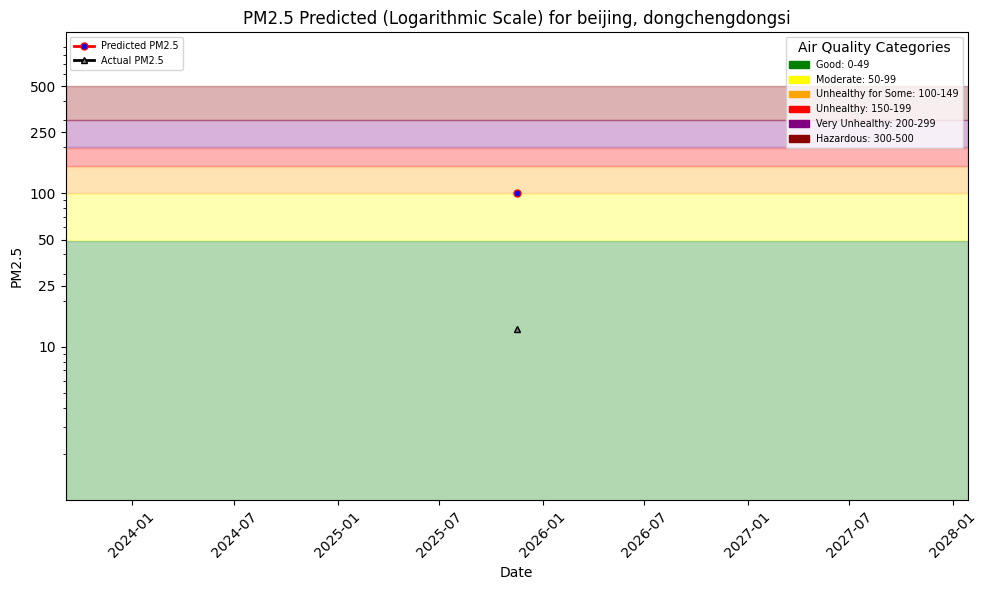

In [32]:
hindcast_file_path_v2 = f"{root_dir}/docs/air-quality/assets/img/pm25_hindcast_1day_v2.png"
plt = util.plot_air_quality_forecast(city, street, hindcast_df_v2, hindcast_file_path_v2, hindcast=True)
plt.show()